In [31]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import json
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import xml.etree.ElementTree as ET
from PIL import Image
import glob
from datetime import datetime
import logging
from tensorflow.keras.utils import Sequence
import random 
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

In [32]:
# Global configuration
IMG_SIZE = (256, 256)  
BATCH_SIZE = 8
EPOCHS = 20
NUM_CLASSES = 2  

In [33]:
def parse_detection_files(data_dir):
    """
    Parse detection text files from the dataset directory structure
    
    Args:
        data_dir: Root directory of the dataset
        
    Returns:
        Dictionary mapping image paths to bounding boxes
    """
    image_to_boxes = {}
    
    for split in ['train', 'val']:
        images_dir = os.path.join(data_dir, split, 'images')
        detections_dir = os.path.join(data_dir, split, 'detections')
        
        # List all subject folders
        subject_folders = [f for f in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, f))]
        
        for subject in subject_folders:
            subject_images_dir = os.path.join(images_dir, subject)
            subject_detections_dir = os.path.join(detections_dir, subject)
            
            # Get all image files
            image_files = [f for f in os.listdir(subject_images_dir) if f.endswith('.png')]
            
            for img_file in image_files:
                img_path = os.path.join(subject_images_dir, img_file)
                detection_file = os.path.join(subject_detections_dir, img_file.replace('.png', '.txt'))
                
                # If detection file exists, parse it
                if os.path.exists(detection_file):
                    boxes = []
                    with open(detection_file, 'r') as f:
                        for line in f:
                            # Try comma-separated first, then space-separated
                            try:
                                # Handle comma-separated values
                                xmin, ymin, xmax, ymax = map(float, line.strip().split(','))
                            except ValueError:
                                try:
                                    # Fallback to space-separated values
                                    xmin, ymin, xmax, ymax = map(float, line.strip().split())
                                except ValueError as e:
                                    print(f"Error parsing line: {line.strip()} in file {detection_file}")
                                    raise e
                                    
                            boxes.append([xmin, ymin, xmax, ymax])
                    
                    # Store the mapping
                    image_to_boxes[img_path] = boxes
                else:
                    # No tumor in the image (include it anyway for training)
                    image_to_boxes[img_path] = []
    
    return image_to_boxes

In [34]:
def visualize_sample(image_path, boxes):
    """
    Visualize an image with its bounding boxes
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding boxes
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()


In [35]:
def prepare_dataset_for_training(image_to_boxes):
    """
    Prepare dataset for training with Faster R-CNN
    
    Returns:
        Lists of training images, training boxes, validation images, validation boxes
    """
    train_images = []
    train_boxes = []
    val_images = []
    val_boxes = []
    
    for img_path, boxes in image_to_boxes.items():
        if '/train/' in img_path:
            train_images.append(img_path)
            train_boxes.append(boxes)
        elif '/val/' in img_path:
            val_images.append(img_path)
            val_boxes.append(boxes)
    
    return train_images, train_boxes, val_images, val_boxes

In [36]:
def get_dataset_stats(image_to_boxes):
    """
    Calculate and print statistics about the dataset
    """
    total_images = len(image_to_boxes)
    images_with_tumors = sum(1 for boxes in image_to_boxes.values() if boxes)
    total_tumors = sum(len(boxes) for boxes in image_to_boxes.values())
    
    print(f"Total images: {total_images}")
    print(f"Images with tumors: {images_with_tumors} ({100 * images_with_tumors / total_images:.2f}%)")
    print(f"Total tumor instances: {total_tumors}")
    print(f"Average tumors per image with tumors: {total_tumors / images_with_tumors:.2f}")
    
    # Calculate average box dimensions
    all_boxes = [box for boxes in image_to_boxes.values() for box in boxes]
    if all_boxes:
        widths = [box[2] - box[0] for box in all_boxes]
        heights = [box[3] - box[1] for box in all_boxes]
        
        print(f"Average tumor width: {sum(widths) / len(widths):.2f} pixels")
        print(f"Average tumor height: {sum(heights) / len(heights):.2f} pixels")

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

# --- Loss Functions ---

def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), tf.float32)
    loss = less_than_one * 0.5 * tf.square(diff) + (1.0 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss)

def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss_fn

# --- Model Definition ---

def build_faster_rcnn_model(trainable=False):  # Set to False to freeze ResNet weights
    input_image = Input(shape=(256, 256, 3), name='input_image')

    # Pretrained backbone
    backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=input_image)
    for layer in backbone.layers:
        layer.trainable = trainable  
    # Head layers
    x = GlobalAveragePooling2D()(backbone.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)

    # Outputs
    class_logits = Dense(2, activation='softmax', name='class_logits')(x)
    bbox_pred = Dense(4, name='bbox_pred')(x)

    # Build model
    model = Model(inputs=input_image, outputs=[class_logits, bbox_pred], name='faster_rcnn')

    # Compile with focal loss + smooth L1
    model.compile(
        optimizer='adam',
        loss={
            'class_logits': focal_loss(gamma=2.0, alpha=0.25),
            'bbox_pred': smooth_l1_loss
        }
    )

    return model


In [38]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.resnet import preprocess_input
import cv2
import numpy as np

class TumorDataset(Sequence):
    def __init__(self, image_paths, boxes, batch_size=8, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.boxes = boxes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.boxes[idx * self.batch_size : (idx + 1) * self.batch_size]

        images = []
        class_labels = []
        bbox_labels = []

        for img_path, bboxes in zip(batch_x, batch_y):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))

            # Augment only if specified
            if self.augment:
                img = self.apply_augmentations(img)

            img = preprocess_input(img.astype(np.float32))
            images.append(img)

            if bboxes:
                box = bboxes[0]
                h, w = 256, 256
                bbox_labels.append([
                    box[0] / w,
                    box[1] / h,
                    box[2] / w,
                    box[3] / h
                ])
                class_labels.append([0, 1])  # Tumor
            else:
                bbox_labels.append([0, 0, 0, 0])  # Dummy box
                class_labels.append([1, 0])      # Background

        return (
            np.array(images),
            {
                'class_logits': np.array(class_labels),
                'bbox_pred': np.array(bbox_labels)
            }
        )

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.boxes))
            np.random.shuffle(temp)
            self.image_paths, self.boxes = zip(*temp)

    def apply_augmentations(self, img):
        # Random horizontal flip
        if np.random.rand() < 0.5:
            img = cv2.flip(img, 1)

        # Random vertical flip
        if np.random.rand() < 0.3:
            img = cv2.flip(img, 0)

        # Brightness & contrast
        if np.random.rand() < 0.5:
            alpha = 1.0 + (np.random.rand() - 0.5) * 0.4
            beta = int((np.random.rand() - 0.5) * 50)
            img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

        # Small rotation
        if np.random.rand() < 0.3:
            angle = np.random.uniform(-15, 15)
            center = (img.shape[1] // 2, img.shape[0] // 2)
            matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]),
                                 flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

        return img


In [56]:
# Replace train_model
def train_model(model, train_images, train_boxes, val_images, val_boxes,callbacks):
    train_data = TumorDataset(train_images, train_boxes)
    val_data = TumorDataset(val_images, val_boxes, shuffle=False)

    model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS

    )

In [40]:
def detect_tumor(model, image_path):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_height, original_width = img.shape[:2]

    img_resized = cv2.resize(img, IMG_SIZE)
    input_img = preprocess_input(img_resized.astype(np.float32))
    input_img = np.expand_dims(input_img, axis=0)

    # Predict using the trained model
    class_probs, bbox_pred = model.predict(input_img)

    # Get predicted class index and confidence
    class_id = np.argmax(class_probs[0])
    confidence = class_probs[0][class_id]

    if class_id == 1 and confidence > 0.5:
        # Get normalized prediction (0–1)
        xmin, ymin, xmax, ymax = bbox_pred[0]

        # Denormalize to original size
        xmin = int(xmin * original_width)
        ymin = int(ymin * original_height)
        xmax = int(xmax * original_width)
        ymax = int(ymax * original_height)

        # Clip values to image bounds
        xmin = max(0, min(xmin, original_width - 1))
        ymin = max(0, min(ymin, original_height - 1))
        xmax = max(0, min(xmax, original_width - 1))
        ymax = max(0, min(ymax, original_height - 1))

        return [(xmin, ymin, xmax, ymax)]
    else:
        return []


In [41]:
def visualize_detection(image_path, boxes):
    """
    Visualize detection results on an image
    
    Args:
        image_path: Path to the input image
        boxes: List of bounding boxes [(xmin, ymin, xmax, ymax), ...]
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding boxes
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f"Detection Results: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

In [42]:
def draw_boxes_comparison(image_path, ground_truth_box, predicted_box):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Ground Truth Box in RED
    if ground_truth_box:
        x1, y1, x2, y2 = map(int, ground_truth_box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, "GT", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Predicted Box in GREEN
    if predicted_box:
        x1, y1, x2, y2 = map(int, predicted_box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, "Pred", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Red: Ground Truth | Green: Prediction")
    plt.show()


In [28]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = inter_area / float(boxA_area + boxB_area - inter_area + 1e-6)
    return iou


In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

def main():
    # Set the data directory
    data_dir = "/kaggle/input/lungtumordetectionandsegmentation"
    
    print("Parsing detection files...")
    image_to_boxes = parse_detection_files(data_dir)
    
    print("Dataset statistics:")
    get_dataset_stats(image_to_boxes)
    
    print("Visualizing sample images...")
    samples = list(image_to_boxes.items())
    random.shuffle(samples)
    for i, (img_path, boxes) in enumerate(samples[:5]):
        if boxes:
            visualize_sample(img_path, boxes)
    
    print("Preparing dataset for training...")
    train_images, train_boxes, val_images, val_boxes = prepare_dataset_for_training(image_to_boxes)
    
    print(f"Training set: {len(train_images)} images")
    print(f"Validation set: {len(val_images)} images")
    
    print("Building Faster R-CNN model...")
    model = build_faster_rcnn_model()

    # Add checkpoint callback
    checkpoint = ModelCheckpoint(
        "faster_rcnn_best_model.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
        
    )

    print("Training the model...")
    train_model(model, train_images, train_boxes, val_images, val_boxes, callbacks=[checkpoint])  # Updated

    # Save final model
    print("Saving final model...")
    model.save("faster_rcnn_final_model.h5")
    
    print("Testing detection on validation images...")
    for i, (img_path, boxes) in enumerate(zip(val_images[:3], val_boxes[:3])):
        if boxes:
            detected_boxes = detect_tumor(model, img_path)
            if detected_boxes:
                draw_boxes_comparison(img_path, boxes[0], detected_boxes[0])
            else:
                print(f"No tumor detected for image: {img_path}")


Parsing detection files...
Dataset statistics:
Total images: 1930
Images with tumors: 1625 (84.20%)
Total tumor instances: 1763
Average tumors per image with tumors: 1.08
Average tumor width: 19.28 pixels
Average tumor height: 18.28 pixels
Visualizing sample images...


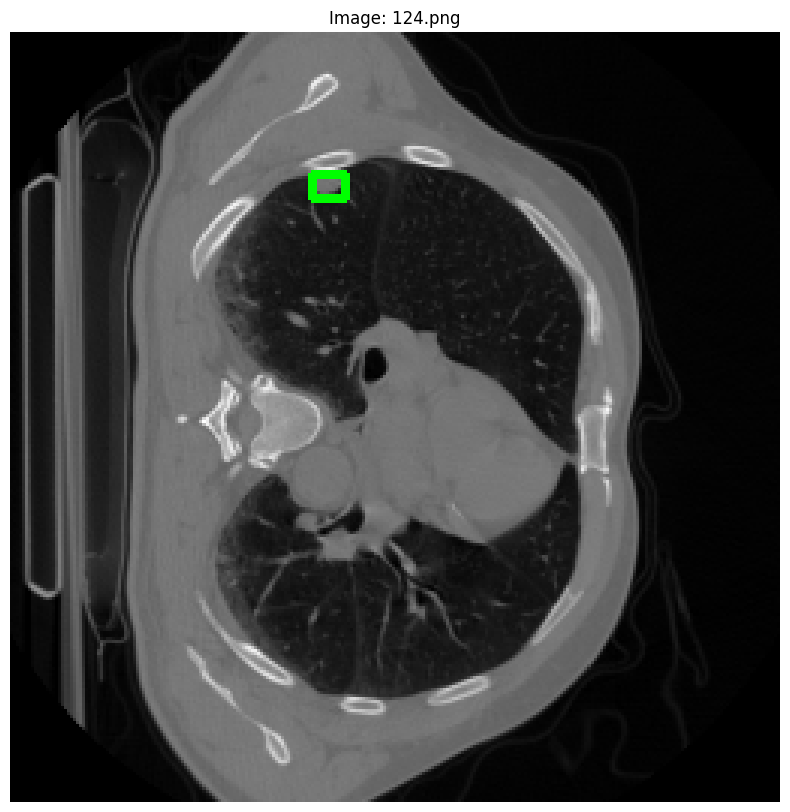

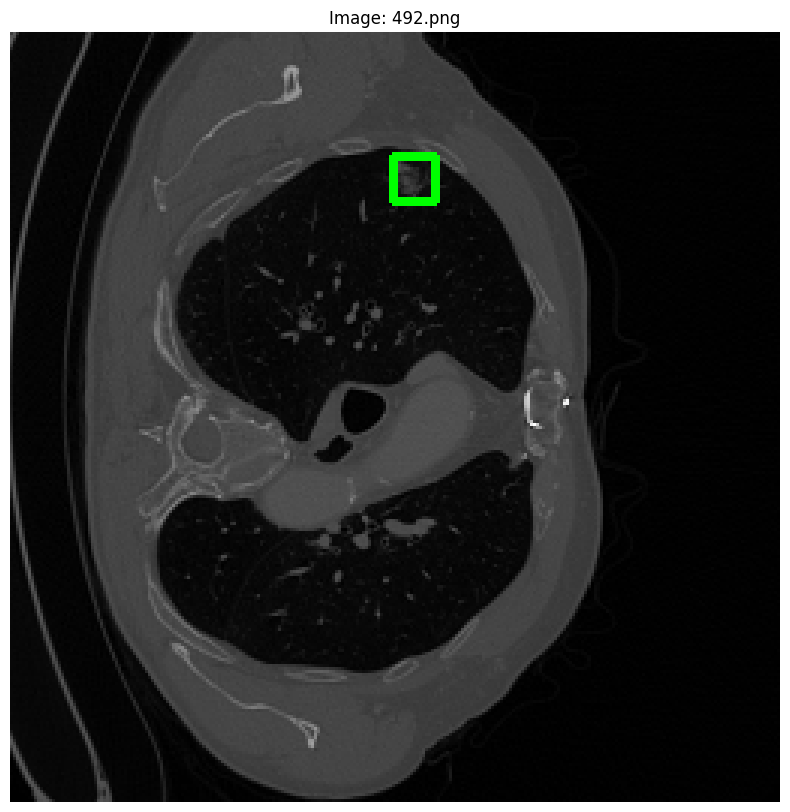

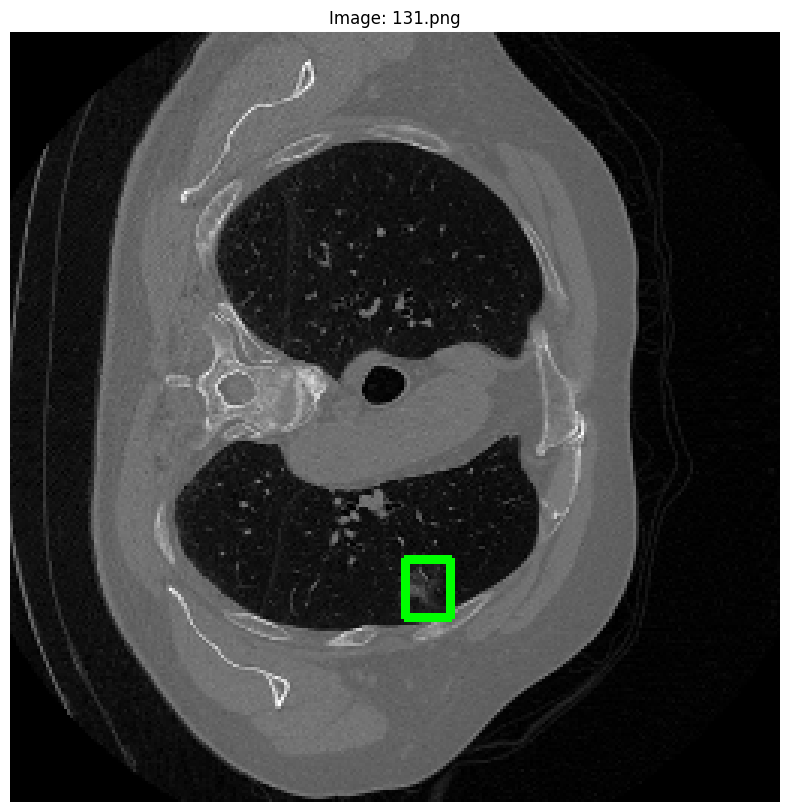

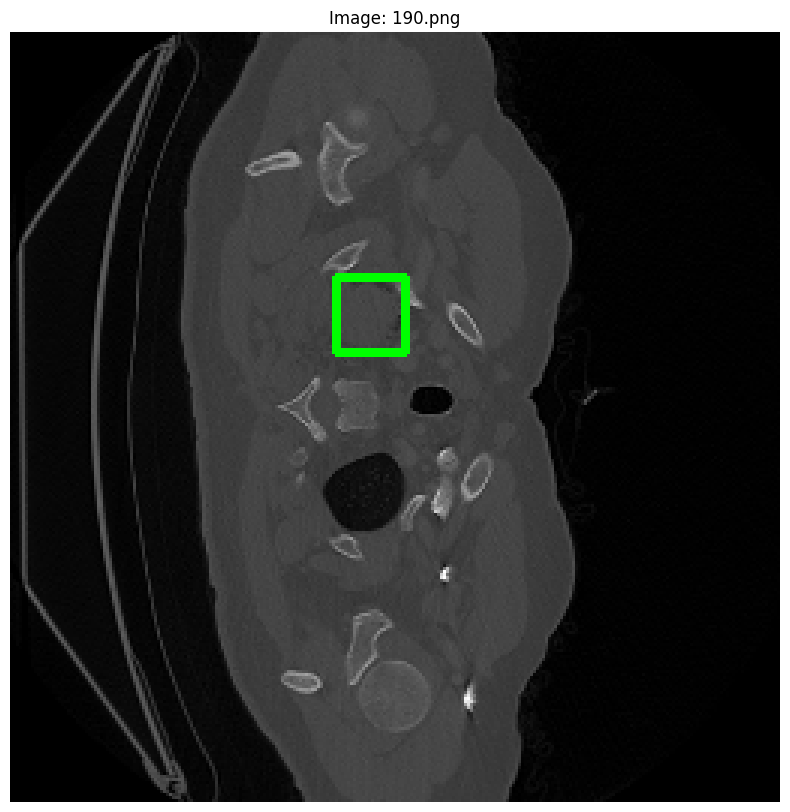

Preparing dataset for training...
Training set: 1832 images
Validation set: 98 images
Building Faster R-CNN model...
Training the model...
Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - bbox_pred_loss: 0.5409 - class_logits_loss: 0.5611 - loss: 1.1020 - val_bbox_pred_loss: 0.0311 - val_class_logits_loss: 0.0176 - val_loss: 0.0488
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - bbox_pred_loss: 0.0251 - class_logits_loss: 0.0150 - loss: 0.0401 - val_bbox_pred_loss: 0.0286 - val_class_logits_loss: 0.0123 - val_loss: 0.0408
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - bbox_pred_loss: 0.0164 - class_logits_loss: 0.0122 - loss: 0.0287 - val_bbox_pred_loss: 0.0271 - val_class_logits_loss: 0.0130 - val_loss: 0.0401
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - bbox_pred_loss: 0.0146 - class_logits_loss: 0.0101 - loss: 0.0248 - val_bbox_pred_loss: 0.0235 - val_class_logits_loss: 0.0113 - val_loss: 0.0347
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - b

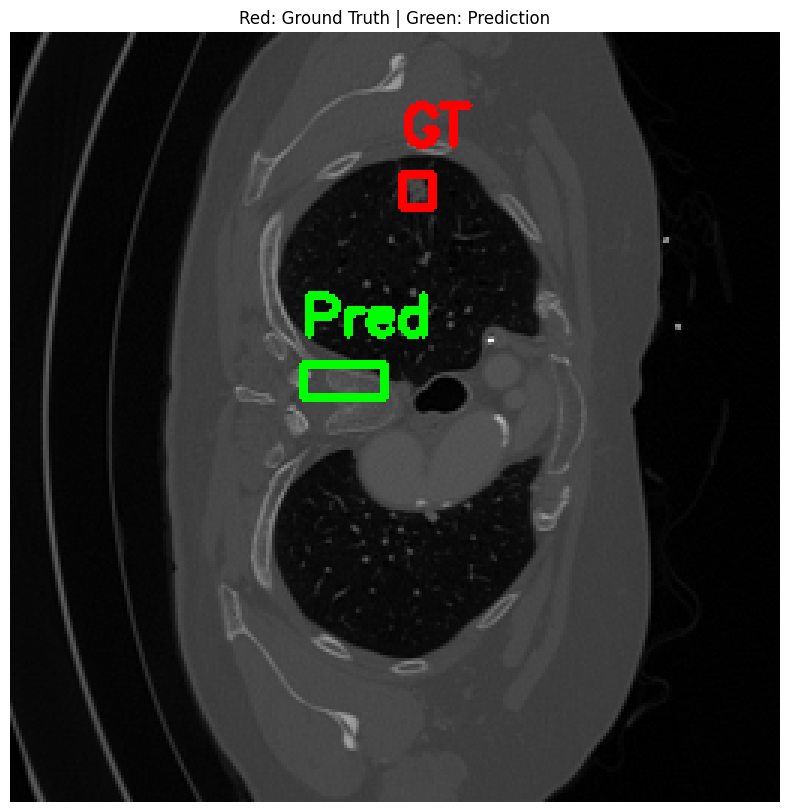

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


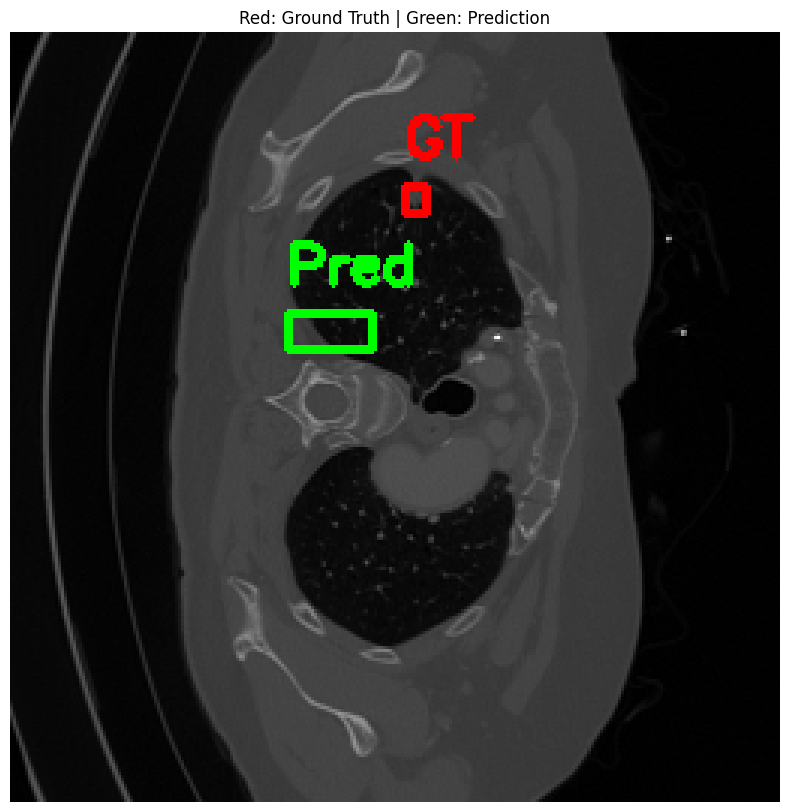

In [58]:
if __name__ == "__main__":
    main()